# Exploratory Data Analysis

#### We load in our data, reshape and merge

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [ ]:
basics = pd.read_csv(r"C:/Users/jungn/OneDrive/Documents/movie project/title.basics.tsv.gz", sep = "\t", compression = "gzip", na_values="\\N")
ratings = pd.read_csv(r"C:/Users/jungn/OneDrive/Documents/movie project/title.ratings.tsv.gz", sep = "\t", compression = "gzip")

#### from the IMDB dataset we only want movies (between 1980-2022), so we exclude tv shows, videos etc

In [ ]:
movies = basics[(basics["titleType"] == "movie") & (basics["startYear"].between(1980, 2022))]
[["tconst", "primaryTitle", "startYear", "runtimeMinutes", "genres"]]

#### We now merge the movies data and ratings data based on "tconst" which is the unique movie ID

In [ ]:
movies = movies.merge(ratings, on="tconst", how="left")

#### Load in the principals data 

In [ ]:
principals = pd.read_csv(r"C:/Users/jungn/OneDrive/Documents/movie project/title.principals.tsv.gz", sep="\t", na_values="\\N")

#### We get the director count and cast size

In [ ]:
principals = principals[principals["category"].isin(["director", "actor", "actress"])]

In [ ]:
director_counts = (principals[principals["category"] == "director"]
    .groupby("tconst")
    .size()
    .rename("num_directors")
    .reset_index()
)

In [ ]:
cast_size = (principals[principals["category"].isin(["actor", "actress"])]
    .groupby("tconst")
    .size()
    .rename("cast_size")
    .reset_index()
)

In [ ]:
movies = (movies
    .merge(director_counts, on="tconst", how="left")
    .merge(cast_size, on="tconst", how="left")
)


In [ ]:
movies[["num_directors", "cast_size"]] = (movies[["num_directors", "cast_size"]].fillna(0))


#### Convert into a csv file 

In [ ]:
movies.to_csv("C:/Users/jungn/OneDrive/Documents/movie project/movies_features.csv", index=False)


In [ ]:
films = pd.read_csv("C:/Users/jungn/OneDrive/Documents/movie project/movies_features.csv")

In [ ]:
films

#### Now we move on to some exploring

In [ ]:
# Total NaN count:
films.isna().any(axis=1).sum()


In [ ]:
# Which columns have NaNs and how many?
films.isna().sum().sort_values(ascending=False)


Above, we see that numVotes and averageRating have the same number of NaNs which means they are missing together. Movies without an IMDB rating is an indication that they are very obscure, and since this project is about how a movie ages in audience pereption these will not serve any purpose so they can be dropped.

In [ ]:
films = films.dropna(subset = ["averageRating", "numVotes"])
films = films.dropna(subset = ["primaryTitle"])
# drop the 2 primaryTitle NaNs as it is a negligible amount

I have decided to keep the rest (genres, runtimeMinutes) as they are still important and will prevent potential bias towards mainstream cinema.

#### Handling runtime NaNs:

In [ ]:
films["runtime_missing"] = films["runtimeMinutes"].isna().astype(int)
films["runtimeMinutes"] = films["runtimeMinutes"].fillna(films["runtimeMinutes"].median())
# Create a new column indicating which rows were NaNs as an integer (0,1) 
# Replace missing values with median runtime of the dataset (mean is not as robust when it comes to extreme values or outliers)

#### Handling genre NaNs:

In [ ]:
films["genres"] = films["genres"].fillna("Unknown") # Replace NaN with Unknown
films["has_genre_info"] = (films["genres"] != "Unknown").astype(int) # Column: Genre info exists, 1. Genre info does not exist, 0.

In [ ]:
films = films.drop("endYear", axis=1)

In [ ]:
films.isna().sum()

In [ ]:
films

- What make a movie a "classic"?
- Given the data:
    - High ratings
    - High review counts
- These are a good indication of "well known" or "famous"

We will explore how many movies in the dataset have an average rating of 7.5 or higher:

In [ ]:
films[films.averageRating >= 7.5].shape[0]

Let's see how many of these movies have review counts in the thousands:

In [ ]:
films.loc[(films["averageRating"] >= 7.5) & (films["numVotes"] >= 1000)].shape[0]

1000 seems a bit arbitrary. We could argue that 500 is a good amount of reviews or 1000 is not enough.

In [ ]:
high = films.loc[films["averageRating"] >= 7.5]

In [ ]:
high["numVotes"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

Above, we see that the top 10% of movies in terms of number of votes with average ratings 7.5 and above have around 782 votes or more. 

In [ ]:
films.loc[(films["averageRating"] >= 7.5) & (films["numVotes"] >= 782)].shape[0]

We now have 4159 movies we could call "classics" as they have high ratings **and** a high number of votes 

What about non-classics which were well recieved at the time of release?
some indications could be:
- high ratings 
- low review count 

One reason for movies not aging well could be that they were following a popular trend at the time such as genre.

In [ ]:
genres = films[["startYear", "genres"]].copy()

In [ ]:
genres["genres"] = genres["genres"].str.split(",")

In [ ]:
genres = genres.explode("genres")

In [ ]:
genrecount = genres.groupby(["startYear","genres"]).size().reset_index(name="count")

In [ ]:
top_genres = (
    genrecount
    .groupby("genres")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(8)
    .index
)

genrecount = genrecount[genrecount["genres"].isin(top_genres)]


In [ ]:
plt.figure(figsize=(12,7))

for genre in top_genres:
    subset = genrecount[genrecount["genres"] == genre]
    plt.plot(subset["startYear"], subset["count"], label=genre)

plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.title("Popularity of Movie Genres Over Time")
plt.legend()
plt.grid(True)
plt.show()

we see that drama has been a popular genre since the 80s, which means a large share of movies released then was following that trend. (It's also interesting to see when the coronavirus hit the film industry the hardest.)

In [ ]:
#Let's take a look at movies with the "drama" genre

drama = films[(films["genres"] == "Drama") & (films["averageRating"] >= 7.5) & (films["numVotes"] >= 782) ]
drama

At a glance, we immediately see a lot of movies that aren't well known despite having higher review counts. One obvious factor is the region the film was produced, as some regions do not have much as much exposure to a global audience compared to others. 

This brings up another important point: Classics can vary by region. For example if you ask someone here in Melbourne if they are familiar with the movie "Chaal Jeevi Laiye" (8.7 rating, 1854 vote count) despite being popular and well known in India you'll most likely get a blank stare. Say you do ask an indian person, they would still need to be fluent in Gujarati as that is the spoken language in the film.

In [ ]:
drama = films[(films["genres"] == "Drama") & (films["averageRating"] >= 7.5) & (films["numVotes"] <= 500) ]
drama

Going back to the "following a trend" idea, we see plenty of examples with high ratings but low vote counts which suggests that trend may definitely an important factor in predicting whether a movie will become a classic or will be forgotten.

**To keep things simple, we will consider all movies with ratings 7.5 and above with vote counts 782 and above "classics"**

In [ ]:
high["numVotes"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

Here we see that the bottom 10% of movies in terms of number of votes with average ratings 7.5 and above have around 9 votes or more. 

In [ ]:
films.loc[(films["averageRating"] >= 7.5) & (films["numVotes"] <= 9)].shape[0]
#There are 5546 movies that were successful ratings wise, but the low number of vote counts suggests that it was/is not popular.

**We will consider these movies as "forgotten"**

To predict whether a movie will be a "Classic" or "Forgotten", we need to see their characteristics.

**"Classics":**

In [ ]:
Classic = films[(films["averageRating"] >= 7.5) & (films["numVotes"] >= 782)]
Classic

**"Forgotten:"**

In [ ]:
Forgotten = films[(films["averageRating"] >= 7.5) & (films["numVotes"] <= 9)]
Forgotten

In [ ]:
films["num_genres"] = films["genres"].str.count(",") + 1

Classic and forgotten refer to audience engagement, not quality.

Let's compare genre presence and genre diversity. We'll compute the genre frequency within each group and normalise to proportions. This will answer the question: "Are classics overrepresented in certain genres?"

Splitting genres into a list:

In [ ]:
classic_genres = Classic[["tconst", "genres"]].copy()
forgotten_genres = Forgotten[["tconst", "genres"]].copy()

In [ ]:
classic_genres["genres"] = classic_genres["genres"].str.split(",")
forgotten_genres["genres"] = forgotten_genres["genres"].str.split(",")

In [ ]:
classic_genres = classic_genres.explode("genres")
forgotten_genres = forgotten_genres.explode("genres")

In [ ]:
classic_genres

,tconst,genres
5,tt0038687,Documentary
5,tt0038687,War
20,tt0067625,Drama
20,tt0067625,War
51,tt0076276,Adventure
...,...,...
395186,tt9883832,Documentary
395186,tt9883832,Music
395370,tt9900782,Action
395370,tt9900782,Crime


Now each row has one instance of genre only

We now compute the frequencies of genres in each

In [ ]:
classic_counts = (classic_genres["genres"].value_counts().reset_index())
classic_counts.columns = ["genre", "count"]


In [ ]:
forgotten_counts = (forgotten_genres["genres"].value_counts().reset_index())
forgotten_counts.columns = ["genre", "count"]


Normalising (out of all genre appearances within this group, what fraction belong to genre X?):

In [ ]:
classic_counts["proportion"] = (classic_counts["count"] / classic_counts["count"].sum())


In [ ]:
forgotten_counts["proportion"] = (forgotten_counts["count"] / forgotten_counts["count"].sum())


In [ ]:
genre_compare = classic_counts.merge(
    forgotten_counts,
    on="genre",
    how="outer",
    suffixes=("_classic", "_forgotten")
).fillna(0)


In [ ]:
genre_compare["over_representation"] = (
    genre_compare["proportion_classic"]
    - genre_compare["proportion_forgotten"]
)


In [ ]:
genre_compare = genre_compare.sort_values(
    "over_representation",
    ascending=False
)


In [ ]:
genre_compare

,genre,count_classic,proportion_classic,count_forgotten,proportion_forgotten,over_representation
8,Drama,2524.0,0.271661,1400,0.186443,0.085218
5,Comedy,954.0,0.102680,456,0.060727,0.041953
6,Crime,572.0,0.061565,148,0.019710,0.041855
19,Romance,529.0,0.056937,215,0.028632,0.028305
0,Action,570.0,0.061350,251,0.033427,0.027923
23,Thriller,364.0,0.039178,128,0.017046,0.022131
3,Animation,248.0,0.026692,41,0.005460,0.021232
2,Adventure,350.0,0.037671,151,0.020109,0.017562
4,Biography,496.0,0.053385,301,0.040085,0.013300
16,Mystery,191.0,0.020558,62,0.008257,0.012301


We see that the genre "Drama" takes the number one spot in terms of proportion for both classics and forgotten movies. As for the over_representation column, if the number is larger and positive that means that the genre is more likely to retain audience engagement amoung movies rated 7.5 and higher.

**Structural differences between classics and forgotten films**

In [ ]:
runtime_compare = (
    pd.concat([
        Classic[["runtimeMinutes"]].assign(group="Classic"),
        Forgotten[["runtimeMinutes"]].assign(group="Forgotten")
    ])
    .dropna()
)



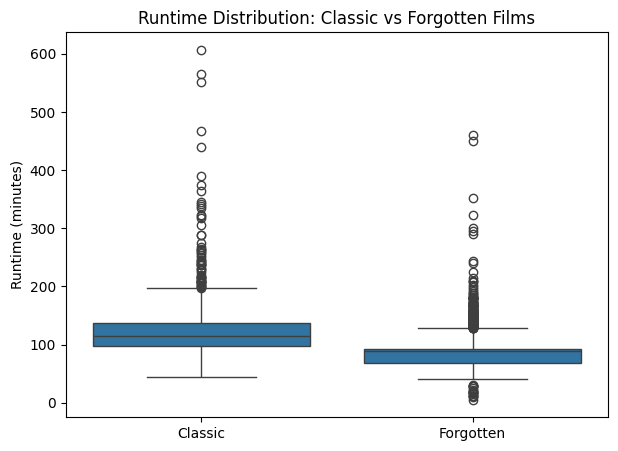

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=runtime_compare,
    x="group",
    y="runtimeMinutes"
)

plt.ylabel("Runtime (minutes)")
plt.xlabel("")
plt.title("Runtime Distribution: Classic vs Forgotten Films")
plt.show()



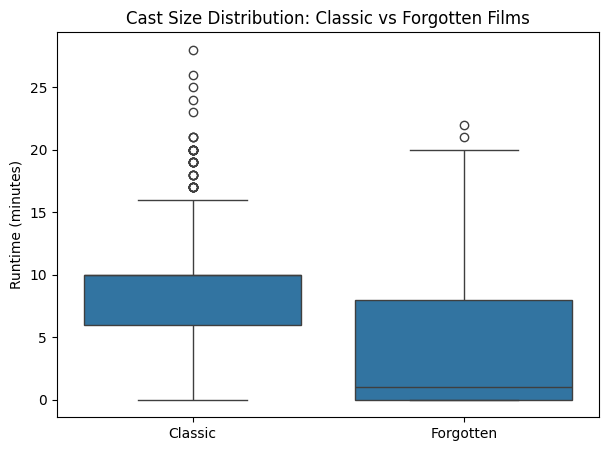

In [ ]:
cast_compare = pd.concat([
    Classic[["cast_size"]].assign(group="Classic"),
    Forgotten[["cast_size"]].assign(group="Forgotten")
])

plt.figure(figsize=(7,5))
sns.boxplot(
    data=cast_compare,
    x="group",
    y="cast_size"
)

plt.ylabel("Runtime (minutes)")
plt.xlabel("")
plt.title("Cast Size Distribution: Classic vs Forgotten Films")
plt.show()

In [ ]:
films["num_genres"] = films["genres"].fillna("").str.split(",").str.len()



In [ ]:
Classic = films[
    (films["averageRating"] >= 7.5) &
    (films["numVotes"] >= 782)
]

Forgotten = films[
    (films["averageRating"] >= 7.5) &
    (films["numVotes"] <= 9)
]



In [ ]:
Classic.columns


Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'num_directors', 'cast_size', 'runtime_missing', 'has_genre_info',
       'num_genres'],
      dtype='object')

In [ ]:
genre_count_compare = pd.DataFrame({
    "num_genres": pd.concat([
        Classic["num_genres"],
        Forgotten["num_genres"]
    ], ignore_index=True),
    "group": (
        ["Classic"] * len(Classic) +
        ["Forgotten"] * len(Forgotten)
    )
})



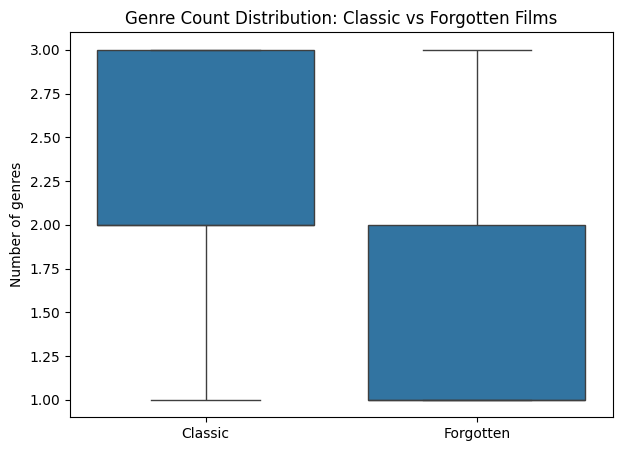

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=genre_count_compare,
    x="group",
    y="num_genres"
)

plt.ylabel("Number of genres")
plt.xlabel("")
plt.title("Genre Count Distribution: Classic vs Forgotten Films")
plt.show()


Classic films exhibit longer runtimes and greater genre diversity than forgotten films, suggesting that structural complexity may play a role in long term audience engagement. Furthermore we can confirm the idea that a greater general cast size has a role in extending the length of a film due to an expanded list of characters.